## **Creating a steel strip defect classification CNN model from scratch**

Note: before running the cell below, make sure that the dataset (zipped file) has been uploaded to Google Drive, Google Drive has been mounted, and the correct path has been specified in the cell below.

In [1]:
# unzip data folder
!unzip -q -o './drive/MyDrive/NEU-data-TrainTest.zip' -d './'

In [2]:
# import packages
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import tensorflow as tf

In [3]:
# Make results reproducible
import os
import random as rn
from numpy.random import seed
seed(2)
tf.random.set_seed(2)
os.environ['PYTHONHASHSEED'] = str(2)
rn.seed(2)

In [4]:
# create iterators to load images
train_datagen = ImageDataGenerator(rescale = 1/255.0, validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1/255.0)

fit_iterator = train_datagen.flow_from_directory(
    directory = './NEU-data-TrainTest/train',
    target_size = (200, 200),
    batch_size = 16,
    class_mode = 'categorical',
    subset='training')

valid_iterator = train_datagen.flow_from_directory(
    directory = './NEU-data-TrainTest/train',
    target_size = (200, 200),
    batch_size = 16,
    class_mode = 'categorical',
    subset='validation')

test_iterator = test_datagen.flow_from_directory(
    directory = './NEU-data-TrainTest/test',
    target_size = (200, 200),
    batch_size = 16,
    class_mode = 'categorical',
    shuffle= False)

Found 1386 images belonging to 6 classes.
Found 342 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [5]:
# check class names
class_names = fit_iterator.class_indices
class_names = list(class_names.keys())
print(class_names)

['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


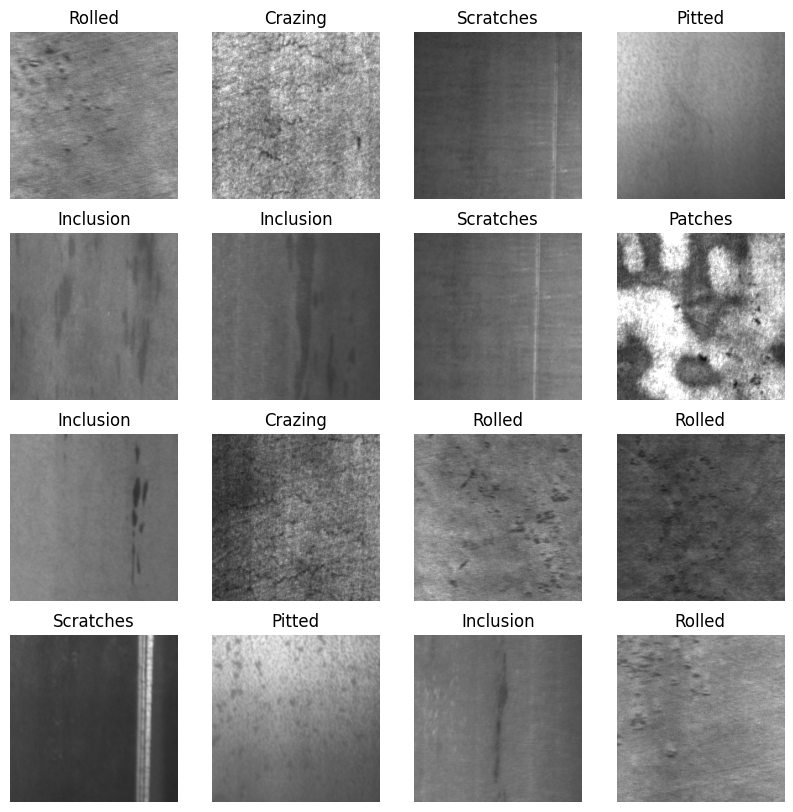

In [6]:
# let's load a few images using the fitting dataset via the iterator
images, labels = fit_iterator.next() # label for each image is in one-hot encoded form

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(16):
    image, label = images[i], labels[i]
    label_name = class_names[np.argmax(label)]
    row, col = i//4, i%4
    axes[row][col].imshow(image)
    axes[row][col].set_title(label_name)
    axes[row][col].axis('off')
plt.show()

In [7]:
# define the CNN model
num_classes = len(class_names)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 128)       0

In [8]:
# compile and fit
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(fit_iterator, epochs = 30, verbose= 1, validation_data = valid_iterator)

Epoch 1/30
87/87 [==============================] - 11s 44ms/step - loss: 1.4351 - accuracy: 0.3954 - val_loss: 0.8041 - val_accuracy: 0.7749
Epoch 2/30
87/87 [==============================] - 3s 35ms/step - loss: 0.8151 - accuracy: 0.6898 - val_loss: 0.7576 - val_accuracy: 0.6871
Epoch 3/30
87/87 [==============================] - 3s 32ms/step - loss: 0.5745 - accuracy: 0.7850 - val_loss: 0.4831 - val_accuracy: 0.8012
Epoch 4/30
87/87 [==============================] - 3s 32ms/step - loss: 0.4277 - accuracy: 0.8420 - val_loss: 0.3367 - val_accuracy: 0.8772
Epoch 5/30
87/87 [==============================] - 3s 32ms/step - loss: 0.3923 - accuracy: 0.8579 - val_loss: 0.5220 - val_accuracy: 0.8099
Epoch 6/30
87/87 [==============================] - 3s 40ms/step - loss: 0.4410 - accuracy: 0.8550 - val_loss: 0.5670 - val_accuracy: 0.8947
Epoch 7/30
87/87 [==============================] - 3s 32ms/step - loss: 0.3207 - accuracy: 0.8918 - val_loss: 0.2006 - val_accuracy: 0.9327
Epoch 8/30
8

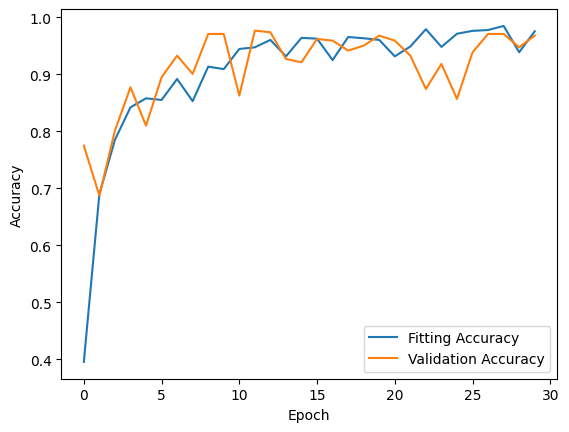

In [9]:
# plot validation curve
plt.figure()
plt.plot(history.history['accuracy'], label='Fitting Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
# check performance on test dataset
result = model.evaluate(test_iterator)
print("Test loss, Test accuracy : ", result)

5/5 [==============================] - 0s 102ms/step - loss: 0.2492 - accuracy: 0.9583
Test loss, Test accuracy :  [0.2491590678691864, 0.9583333134651184]


5/5 [==============================] - 0s 18ms/step


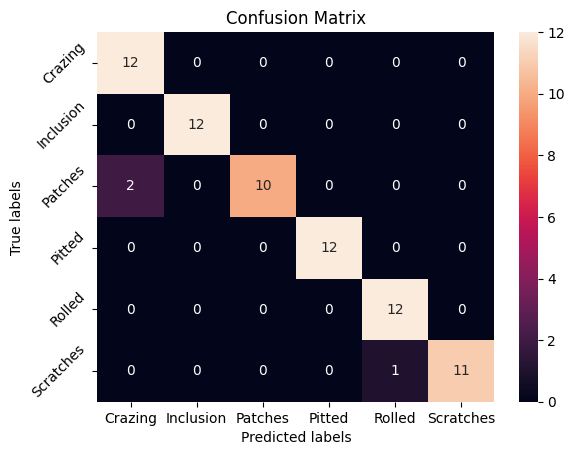

In [11]:
# plot confusion matrix for test dataset
from sklearn.metrics import confusion_matrix
import seaborn as sns

probs_preds = model.predict(test_iterator) # each image is assigned 6 probabilities corresponding to the 6 fault classes
labels_preds = probs_preds.argmax(axis=1) # numeric label for each image
conf_matrix = confusion_matrix(test_iterator.classes, labels_preds)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, fmt='g',  annot=True)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix');

ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names, rotation=45)
plt.show()
